# Run a complete consensus workflow

Based on [this workflow](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/index.html)

![](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/overview-Consensus.png)

The steps are as follows:
 1. Data input and cleaning, including re-formatting the data for consensus analysis: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-DataInput.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-DataInput.R)
 1. Network construction and consensus module detection
    1. Automatic, one-step network construction and consensus module detection: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-auto.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-auto.R) **THIS ONE**
    1. Step-by-step network construction and module detection, including scaling of Topological Overlap Matrices: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-man.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-man.R)
    1. Dealing with large datasets: block-wise network construction and consensus module detection, including comparing the block-wise approach to the standard single-block method: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-blockwise.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-blockwise.R).
 1. Relating the consensus modules to female set-specific modules (this section requires the results of Section 2.a of the female turorial): [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-RelateToFemMods.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-RelateToFemMods.R)
 1. Relating consensus module to external microarray sample traits and exporting the results of network analysis: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-RelateModsToTraits.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-RelateModsToTraits.R)
 1. Studying and comparing the relationships among modules and traits between the two data sets, including the visualization of consensus eigengene networks and the results of the differential analysis: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-EigengeneNetworks.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-EigengeneNetworks.R)

## Perform the cleaning

In [2]:
library(RaceID)
library(WGCNA)

In [3]:
sc <- readRDS('~/Downloads/sc_object_RaceID.RDS')
mydata <- sc@expdata

The data contains two sets of **K**ases and **C**ontrols

In [17]:
tab <- as.matrix(mydata)
controls <- grepl("^C8", colnames(tab))
kases <- grepl("^K8*", colnames(tab))

In [22]:
print(paste("Controls=", sum(controls), " Cases=", sum(kases), " (+added) ", 
      (sum(controls) + sum(kases)), " expected=", length(colnames(tab))))

[1] "Controls= 1417  Cases= 2718  (+added)  4135  expected= 4135"


### Building the multiExpr set

In [29]:
# transpose for compatibility
data.controls <- t(tab[,controls])
data.kases <- t(tab[,kases])

In [30]:
nSets = 2
setLabels = c("Cases (K)", "Controls (C)")
shortLabels = c("Cases", "Controls")

multiExpr = vector(mode = "list", length = nSets)
multiExpr[[1]] = list(data = as.data.frame(data.kases))
multiExpr[[2]] = list(data = as.data.frame(data.controls))

names(multiExpr[[1]]$data) = colnames(data.kases)
names(multiExpr[[2]]$data) = colnames(data.controls)

rownames(multiExpr[[1]]$data) = rownames(data.kases)
rownames(multiExpr[[2]]$data) = rownames(data.controls)

In [31]:
# Check that the data has the correct format for many functions operating on multiple sets:
exprSize = checkSets(multiExpr)

In [32]:
exprSize

$nSets
[1] 2

$nGenes
[1] 23774

$nSamples
[1] 2718 1417

$structureOK
[1] TRUE

## Cleaning and Outlier Removal

In [33]:
gsg = goodSamplesGenesMS(multiExpr, verbose = 3);
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 6991 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 6991, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 6991, bad sample counts: 0, 0


[1] FALSE

Nope, we need to prune some samples

In [35]:
if (!gsg$allOK){
    # Print information about the removed genes:
    if (sum(!gsg$goodGenes) > 0){
        printFlush(paste("Removing genes:", 
                         paste(names(multiExpr[[1]]$data)[!gsg$goodGenes],
                               collapse = ", ")));
    }
    for (set in 1:exprSize$nSets){
        if (sum(!gsg$goodSamples[[set]])){
            printFlush(paste("In set", setLabels[set], "removing samples",
                             paste(rownames(multiExpr[[set]]$data)[!gsg$goodSamples[[set]]], 
                                   collapse = ", ")))
        } 
        # Remove the offending genes and samples
        multiExpr[[set]]$data = multiExpr[[set]]$data[gsg$goodSamples[[set]], gsg$goodGenes];
    }
    # Update exprSize
    exprSize = checkSets(multiExpr)
}

Removing genes: Cd209f, Ugt3a1, Usp17lb, V1ra8, Vmn1r10, Vmn1r16, Vmn1r167, Vmn1r168, Vmn1r17, Vmn1r172, Cd300lh, Vmn1r18, Vmn1r184, Vmn1r189, Vmn1r192, Vmn1r193, Vmn1r197, Vmn1r2, Vmn1r25, Vmn1r33, Vmn1r40, Vmn1r42, Vmn1r86, Vmn2r-ps130, Cela3a, Vmn2r108, Vmn2r20, Vmn2r23, Vmn2r58, Ces1b, Vmn2r88, Wfdc6a, Xlr5a, Ces2c, n-R5s166, Ces3a, n-R5s176, n-R5s194, n-R5s10, 1700040F15Rik, Cldn34b1, Cldn34c2, Clec2g, Cml3, Cphx1, Crisp1, Crygd, Cts3, Cyp2a12, Cyp2a4, Cyp2b13, Cyp2c40, Cyp2d10, Cyp4a12a, Cypt14, Cypt2, D13Ertd608e, 1810009J06Rik, D830030K20Rik, DXBay18, Dcpp1, Defa-rs7, Defa2, Defb10, Defb15, Dmrtc1c1, Dsg1b, E330010L02Rik, E330016L19Rik, Ear1, Entpd4, Fbxw25, Fpr-rs6, Fthl17b, Gal3st2, 4921509C19Rik, 4921511M17Rik, 4930442J19Rik, Dppa1, 4930449I24Rik, 4930524N10Rik, 4930558F17Rik, 4933402N22Rik, 4933406F09Rik, 1700003E24Rik, 5430401F13Rik, 5430402E10Rik, 9230110F15Rik, AC099934.1, 1700010D01Rik, AC099934.2, AC124193.1, AC125099.1, AL645522.1, 1700011M02Rik, AV320801, AW822073, A

Check again:

In [37]:
exprSize

$nSets
[1] 2

$nGenes
[1] 16783

$nSamples
[1] 2718 1417

$structureOK
[1] TRUE

In [38]:
gsg = goodSamplesGenesMS(multiExpr, verbose = 3);
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


[1] TRUE

Okay, we can now proceed with the clustering using Euclidean as a distance metric

In [39]:
sampleTrees = list()
for (set in 1:nSets){
    sampleTrees[[set]] = hclust(dist(multiExpr[[set]]$data), method = "average")
}

In [40]:
pdf(file = "Plots/SampleClustering.pdf", width = 12, height = 12);
par(mfrow=c(2, 1))
par(mar = c(0, 4, 2, 0))
for (set in 1:nSets){
    plot(sampleTrees[[set]], 
         main = paste("Sample clustering on all genes in", setLabels[set]),
         xlab="", sub="", cex = 0.7)
}
dev.off()

png 
  2

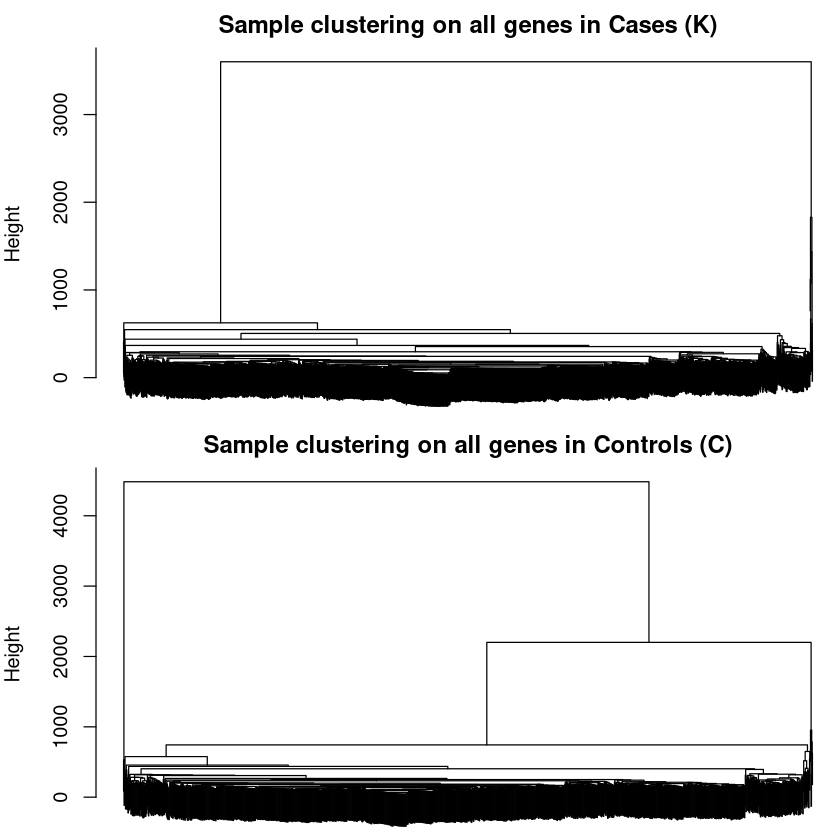

In [59]:
par(mfrow=c(2, 1))
par(mar = c(0, 4, 2, 0))
for (set in 1:nSets){
    plot(sampleTrees[[set]], 
         main = paste("Sample clustering on all genes in", setLabels[set]),
         xlab="", sub="", cex = 1e-20)
}

there appears to be a few small outliers in the cases (far right) which cluster immediately alone, so maybe it makes sense to remove them? We can set a base height cut off at 2000

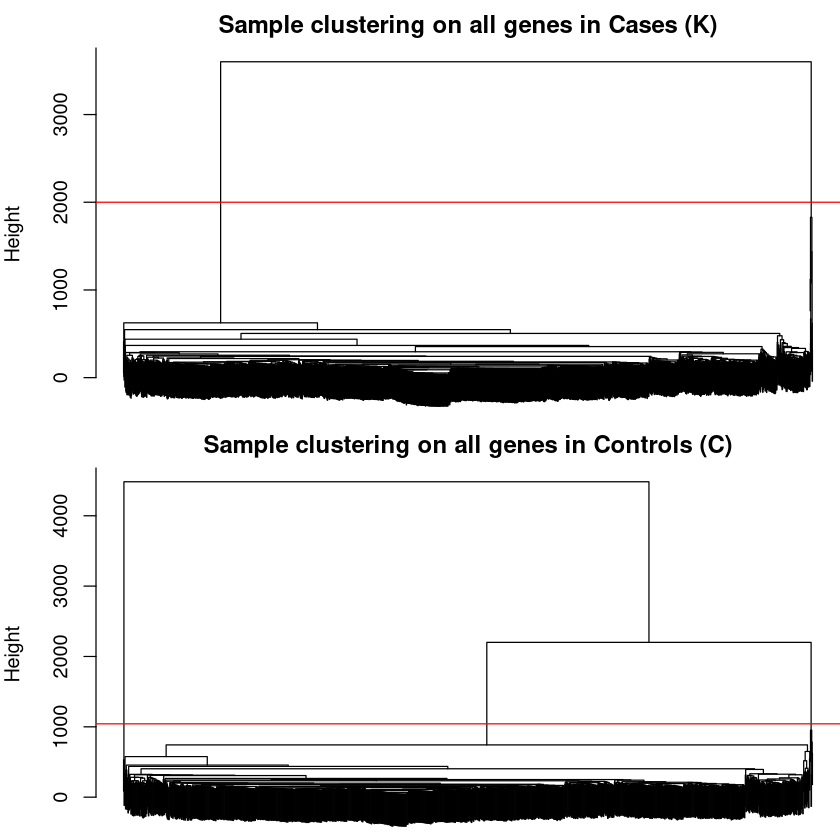

In [63]:
baseHeight = 2000
cutHeights = c(baseHeight, baseHeight * exprSize$nSamples[2]/exprSize$nSamples[1])

par(mfrow=c(2, 1))
par(mar = c(0, 4, 2, 0))
for (set in 1:nSets){
    plot(sampleTrees[[set]], 
         main = paste("Sample clustering on all genes in", setLabels[set]),
         xlab="", sub="", cex = 1e-20)
    abline(h=cutHeights[set], col = "red");
}

and now we trim:

In [64]:
for (set in 1:nSets){
    # Find clusters cut by the line
    labels = cutreeStatic(sampleTrees[[set]], 
                          cutHeight = cutHeights[set])
    # Keep the largest one (labeled by the number 1)
    keep = (labels==1)
    multiExpr[[set]]$data = multiExpr[[set]]$data[keep, ]
}
collectGarbage();# Check the size of the leftover data
exprSize = checkSets(multiExpr)
exprSize

$nSets
[1] 2

$nGenes
[1] 16783

$nSamples
[1] 2708 1409

$structureOK
[1] TRUE

In [67]:
saveRDS(c(multiExpr, exprSize, sampleTrees), file = "files/7_wgcna2/checkpoint.RDS")